# Example 5: Heading dependence

Inspect how grid maps change depending on the animal's heading. 
See `heading.py` for subroutines used in this notebook. 

Neuron `r2405_051216b_cell1816` was recorded by Dr. Marius Bauza and the Krupic lab; They have kindly shared this data to evaluate these GP methods. Please cite their work as

> Krupic J, Bauza M, Burton S, O’Keefe J. Local transformations of the hippocampal cognitive map. Science. 2018 Mar 9;359(6380):1143-6.

## Setup workspace, load, and prepare dataset

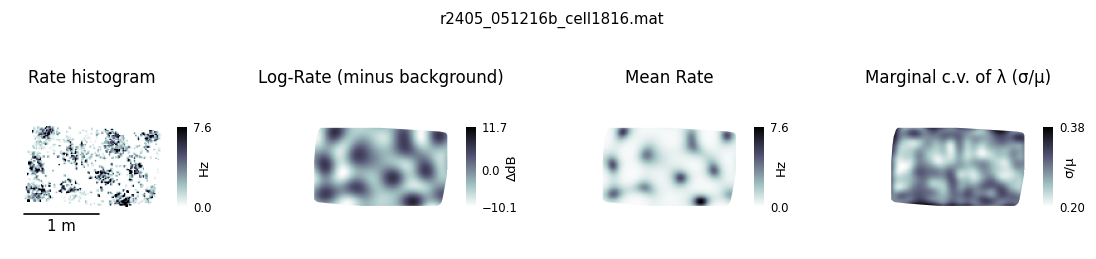

In [1]:
%load_ext autoreload
%autoreload 2
from scipy.io import loadmat
import sys
sys.path.append('../')
from lgcpspatial.loaddata import Dataset
from lgcpspatial.lgcp2d   import lgcpregress
from lgcpspatial.plot     import inference_summary_plot

# Load dataset R11_20190607_EC_02
L        = 128 # Grid size for position bins
dataset  = 'r2405_051216b_cell1816.mat'
datadir  = '../example data/'
data     = Dataset.from_file(datadir + dataset).prepare(L)

# Use parameters found by optimize_hyperparameters.ipynb
P     = 23.58975  # Grid period
v0    = 0.4109905 # Log-rate prior covariance kernel peak variance (zero lag variance)
result = lgcpregress(data,v0,P)
inference_summary_plot(result,ftitle=dataset);

## Fit maps for a range of heading angles

The inferred location of peaks changes depending on heading. This quickly searches all heading directions to find peaks that are well-localized in all directions. We look for peaks that can be identified uniquely over a good range of heading directions. 

In [2]:
import numpy as np
from lgcpspatial.heading import get_peaks_at_heading_angles
from lgcpspatial.heading import link_peaks

# High-resolution heading angle sweep
# Don't re-optimize kernel variance here (faster, 
# sufficiently accurate for peak locations, less-meaningful
# posterior confidence)
Nphi = 36
phis = np.linspace(0,2*np.pi,Nphi+1)[:-1]

# Grab peaks at a range of heading angles, then
# locate peaks tracked over a range of heading angles
peaks,models,fits = get_peaks_at_heading_angles(
    result,
    phis,
    threshold     = 0,
    return_models = True,
    return_fits   = True
)

## Identify shifted versions of the same grid field

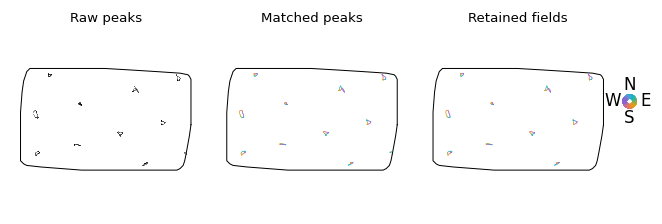

In [3]:
from lgcpspatial.heading import match_peaks
from lgcpspatial.heading import plot_tracked_peaks
from lgcpspatial.plot    import *

# Largest separation between peaks at adjacent heading angles
# allowed for assuming two peaks come from the same field. 
maximum_point_distance = (P/L)*15/Nphi

figure(0,(5,2),120)
subplots_adjust(0,0,1,1,0.1,0)

subplot(131)
for q in peaks:
    scatter(*q,s=.1,lw=0,color='k')
plot(*data.arena.perimeter.T,color='k',lw=.6)
title('Raw peaks',pad=0)
axis('square')
axis('off')
ym = mean(q[1])
dy = diff(ylim())*0.5
ylim(ym-dy,ym+dy)
xl,yl = xlim(),ylim()

subplot(132)
edges = match_peaks(peaks,maximum_point_distance)  
plot_tracked_peaks(peaks,edges,lw=.4,compass=False)
plot(*data.arena.perimeter.T,color='k',lw=.6)
title('Matched peaks',pad=0)
axis('square')
axis('off')
xlim(*xl); ylim(*yl)

subplot(133)
edges = link_peaks(peaks,maximum_point_distance)  
plot_tracked_peaks(peaks,edges,lw=.4)
plot(*data.arena.perimeter.T,color='k',lw=.6)
title('Retained fields',pad=0)
axis('square')
axis('off')
xlim(*xl); ylim(*yl);

## Get confidence intervals for maps in cardinal directions

Re-optimizing the kernel variance will adjust the posterior confidence
intervals to account for the fact that, due to heading-dependent weighting, each heading direction now has a different effective number of sampled. 

We are focus on opposite heading directions because these are fit on entirely non-overlapping sets of data, due to the heading weights tapering to zero for opposing directions. 

In [4]:
from lgcpspatial.heading import smoothed_heading_angle
from lgcpspatial.heading import fit_heading_variance

angleNSEW = float32([pi/2,3*pi/2,pi,0])

models, fits = fit_heading_variance(
    result,
    smoothed_heading_angle(data.px,data.py),
    angleNSEW)

[7](1.52e+00) loss=-3.165055e+033(done)
σ0   = 0.410990
β    = 1.319508
σ0/β = 0.311473
[12](7.58e-01) loss=-2.932043e+03(done)
σ0   = 0.311473
β    = 0.870551
σ0/β = 0.357788
[8](1.32e+00) loss=-2.874970e+033(done)
σ0   = 0.357788
β    = 1.148698
σ0/β = 0.311473
[9](1.15e+00) loss=-3.067678e+033(done)
σ0   = 0.311473
β    = 1.000000
σ0/β = 0.311473


### Get sampled confidence intervals for each direction

The reason we fit separate models, as opposed to introducing heading as a new dimension in our Gaussian process, is that we want the resulting posteriors to be statistically independent for opposing directions. For a Gaussian process, even if the prior kernel for heading angle were to taper to zero for opposing directions, this would nor guarantee that the GP posteriors for oppsing directions are statistically independent. 

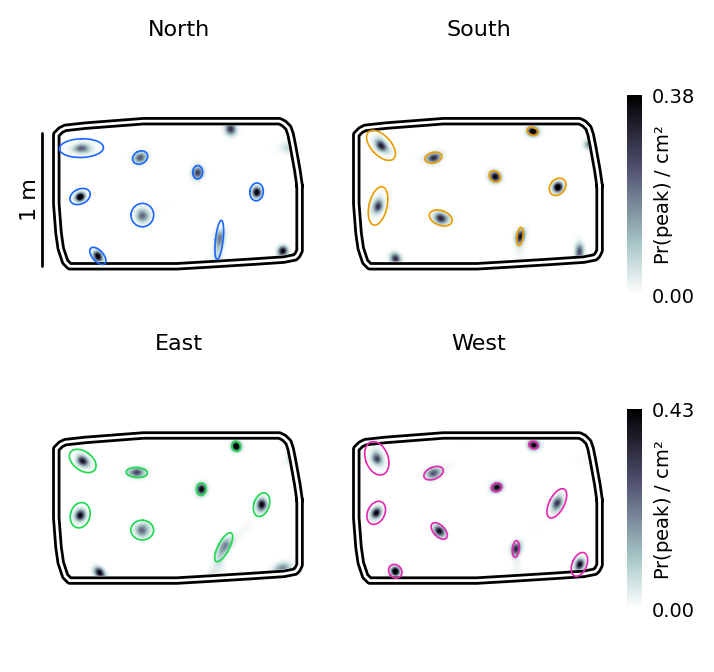

In [5]:
from lgcpspatial.heading import sample_heading_angles

resolution = 4
nsamples   = 2000
colorNSEW  = float32([
    [0.1,0.4,1.0], # North color
    [.91,.61,0.0], # South color
    [0.1,.85,0.3], # East  color
    [0.9,.15,0.7]  # West  color
])
titleNSEW = 'North South East West'.split()
samples = sample_heading_angles(
    data,
    models,
    fits,
    angleNSEW,
    nsamples   = nsamples,
    resolution = resolution,
    names      = titleNSEW,
    colors     = colorNSEW)